In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 990.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 16.00 MiB/s, done.


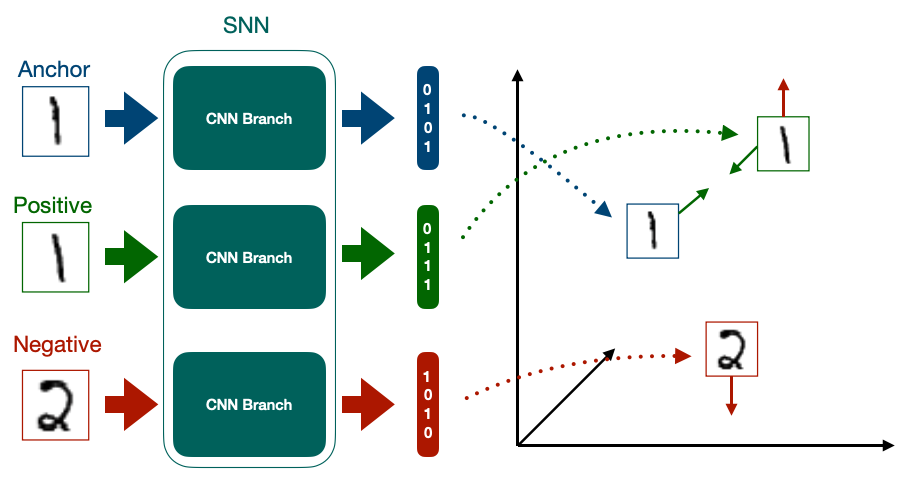

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [13]:
row = df.iloc[14]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

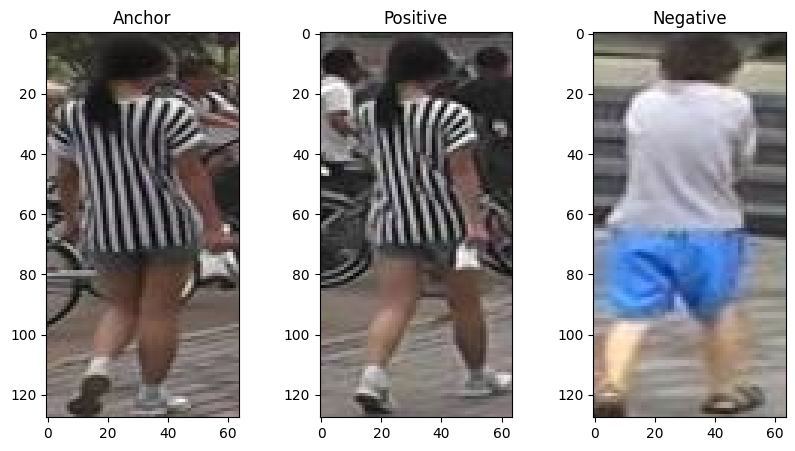

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [25]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)
    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0
    return A_img, P_img, N_img

In [26]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


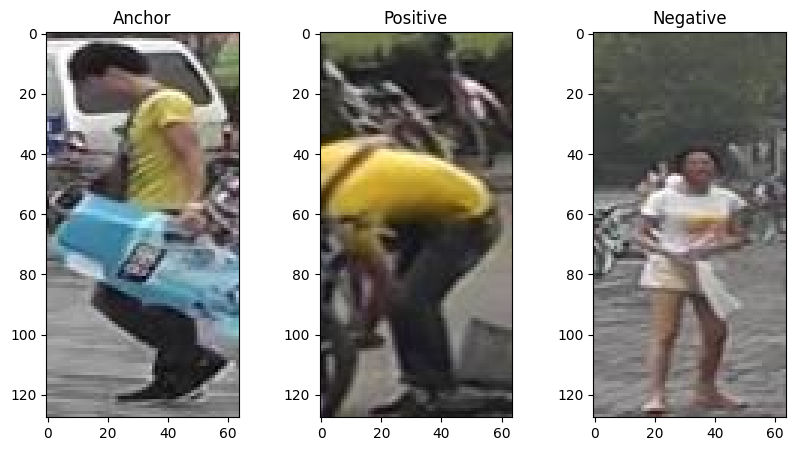

In [27]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [28]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [29]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [30]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [33]:
class APN_Model(nn.Module):
  def __init__(self,emb_size=512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)
  def forward(self,images):
    embeddings = self.efficientnet(images)
    return embeddings

In [35]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [36]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss=0.0
  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    loss = criterion(A_embs, P_embs, N_embs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/len(dataloader)

In [37]:
def eval_fn(model, dataloader, criterion):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)
      loss = criterion(A_embs, P_embs, N_embs)
      total_loss += loss.item()
    return total_loss/len(dataloader)

In [38]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [40]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss<best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'model.pth')
    print("SAVED_WEIGHTS_SUCCESS")
  print(f"EPOCHS:{i+1} tain_loss:{train_loss} valid_loss:{valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.57it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS:1 tain_loss:0.2766291409730911 valid_loss:0.3650551152229309


100%|██████████| 25/25 [00:03<00:00,  7.72it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS:2 tain_loss:0.19582122042775155 valid_loss:0.19057530760765076


100%|██████████| 25/25 [00:03<00:00,  7.78it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS:3 tain_loss:0.07850181192159653 valid_loss:0.15500383138656615


100%|██████████| 25/25 [00:03<00:00,  7.80it/s]


EPOCHS:4 tain_loss:0.03935329429805279 valid_loss:0.1644188207387924


100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


EPOCHS:5 tain_loss:0.05258568659424782 valid_loss:0.1700107079744339


100%|██████████| 25/25 [00:05<00:00,  4.44it/s]


EPOCHS:6 tain_loss:0.057649976760149005 valid_loss:0.280676903128624


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


EPOCHS:7 tain_loss:0.0876216447353363 valid_loss:0.20518702417612075


100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


EPOCHS:8 tain_loss:0.06630237758159638 valid_loss:0.1645437002182007


100%|██████████| 25/25 [00:03<00:00,  7.71it/s]


EPOCHS:9 tain_loss:0.05367887064814567 valid_loss:0.21215761780738832


100%|██████████| 25/25 [00:03<00:00,  6.25it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS:10 tain_loss:0.03201325535774231 valid_loss:0.14900232315063477


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


EPOCHS:11 tain_loss:0.024062357619404794 valid_loss:0.22860768496990203


100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


EPOCHS:12 tain_loss:0.029697178602218627 valid_loss:0.1751947993040085


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


EPOCHS:13 tain_loss:0.048445463627576825 valid_loss:0.2879830980300903


100%|██████████| 25/25 [00:05<00:00,  4.89it/s]


EPOCHS:14 tain_loss:0.06429675117135047 valid_loss:0.20367726922035218


100%|██████████| 25/25 [00:03<00:00,  7.73it/s]

EPOCHS:15 tain_loss:0.05475687861442566 valid_loss:0.15345993161201477


# Get Anchor Embeddings

In [41]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings=[]
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [44]:
model.load_state_dict(torch.load('model.pth'))
df_enc = get_encoding_csv(model, df.Anchor)

100%|██████████| 4000/4000 [00:47<00:00, 84.59it/s]


In [45]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.629321,-0.505834,-0.555280,0.461472,-0.197510,-0.282817,0.337622,-0.364797,-0.429285,...,0.115709,-0.529809,-0.379687,0.106463,0.826470,-1.076467,0.335520,0.247013,0.475701,-0.057889
1,1420_c3s3_061978_03.jpg,-0.659276,-0.401580,-0.356911,0.244542,-0.179907,-0.141930,0.395578,-0.438607,-0.552254,...,-0.173962,-0.510499,-0.278941,0.163758,0.874966,-0.321828,0.519652,0.133644,0.367468,-0.317827
2,1420_c5s3_062565_05.jpg,-0.793953,-0.716279,-0.625753,0.766411,-0.149341,-0.238556,0.564943,-0.400209,-0.522266,...,0.157877,-0.743016,-0.681408,0.210419,1.000053,-1.190094,0.663823,0.246549,0.488623,0.062161
3,1420_c6s3_085592_04.jpg,-0.426301,-0.536535,-0.618070,0.289127,-0.414876,-0.027290,0.087530,-0.495365,-0.602368,...,-0.200930,-0.165253,-0.027525,0.250904,0.588475,-0.090305,0.353237,0.020087,0.407052,-0.107904
4,0663_c5s3_085987_03.jpg,0.602524,-0.602965,-0.385548,-0.565723,-0.144304,0.417738,-1.013927,-0.619405,-0.109717,...,-0.524615,0.478365,0.277210,0.313771,-0.289968,0.387405,-0.471626,-0.504080,0.072368,-0.045318


# Inference

In [46]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc - anc_enc_arr).T))
  return dist

In [63]:
idx = 50
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name
img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [64]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [65]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1,:])
  distance = np.append(distance, dist)

In [66]:
closest_idx = np.argsort(distance)

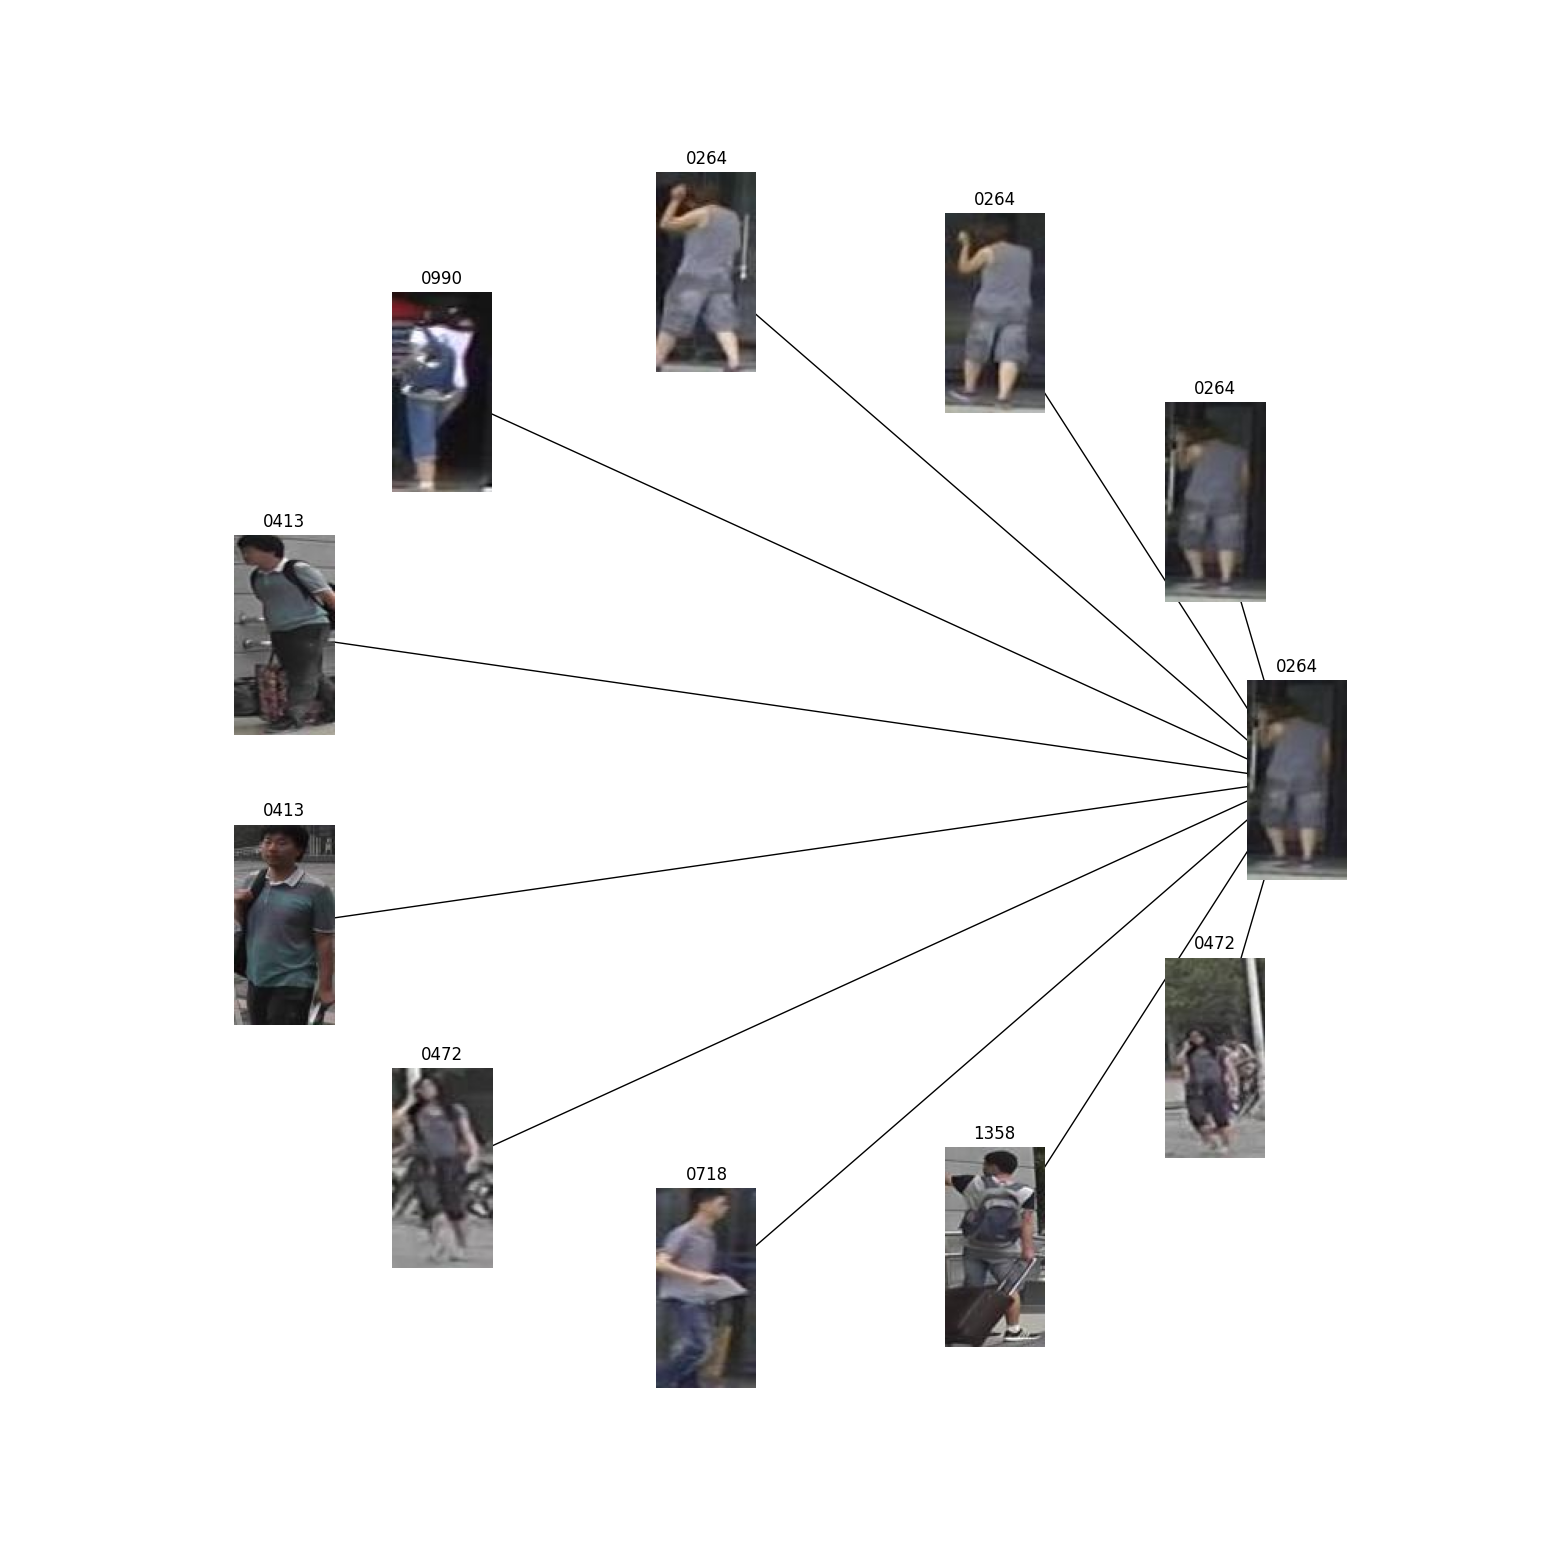

In [67]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);